In [1]:
import pandas as pd
import os
import sys
import csv
import numpy as np
import ast
from spacy.matcher import PhraseMatcher
from spacy import displacy

# Get the parent directory of the current directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the parent directory to the Python path
sys.path.append(parent_dir)
import myutils
from config import Config

/Users/felix/opt/anaconda3/envs/thesis3.9/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.0.1) doesn't match a supported version!
  warnings.warn(


In [2]:
config = Config()
rubrics = myutils.load_rubrics('../' + config.PATH_RUBRIC)

# are long rubrics an issue?
lens = {}
for k,v in rubrics.items():
    lens[k] = len(v['key_element'].tolist())

sorted_lens = sorted(lens.items(), key=lambda x: x[1], reverse=True)
print(sorted_lens)

[('7', 4), ('1', 4), ('3', 4), ('6', 2), ('4', 2), ('8', 2)]


In [3]:
# how much similar spans do we predict?

duplicates = []
differences = []
lengths = []
# Open the CSV file and read its contents
with open('../results/grading_final_decision_tree_span_prediction_regression/final_prediction.csv', 'r') as csv_file:
    reader = csv.DictReader(csv_file)

    # Iterate over each row in the CSV file
    for row in reader:
        # Extract the justification_cues column as a string
        justification_cues_str = row['justification_cues']
        
        # Convert the string representation of the list of tuples to an actual list
        justification_cues = eval(justification_cues_str)
        
        duplicates.append(len(justification_cues) != len(set(justification_cues)))
        differences.append(len(justification_cues) - len(set(justification_cues)))
        lengths.append(len(justification_cues))
print(len([d for d in duplicates if d==True]))
print(np.average(differences))
        

151
0.7859778597785978


In [4]:
converters = {
    'justification_cues': ast.literal_eval,
    'scoring_vectors': ast.literal_eval,
    'justification_cue_spans': ast.literal_eval,
}

In [10]:
# calculate metrics without unseen questions
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

german_ids = [i for i in range(0,9)]

unseen_question_ids = ['2', '5', '1.2', '11.1_SDN', '11.2_SDN', '11.3_SDN', '11.4_SDN']

In [11]:
file_paths = ['../results/grading_final_decision_tree_span_prediction_regression/final_prediction.csv',
              '../results/grading_final_decision_tree_token_classification_regression/final_prediction.csv',
              '../results/grading_final_summation_span_prediction_regression/final_prediction.csv',
              '../results/grading_final_summation_token_classification_regression/final_prediction.csv',
             ] 

In [14]:
for file_path in file_paths:
    y_true_de, y_pred_de = [], []
    y_true_en, y_pred_en = [], []
    predictions = pd.read_csv(file_path, converters=converters)
    for i, p in predictions.iterrows():
        if p['question_id'] not in unseen_question_ids:
            if p['question_id'] in german_ids:
                y_true_de.append(float(p['score']))
                y_pred_de.append(float(p['y_pred']))
            else:
                y_true_en.append(float(p['score']))
                y_pred_en.append(float(p['y_pred']))
    print(file_path.split('/')[2])
    print('DE', mean_squared_error(y_true_de, y_pred_de, squared=True))
    #print('EN', mean_squared_error(y_true_en, y_pred_en, squared=True))
    y_true_de = [str(i) for i in y_true_de]
    y_pred_de = [str(i) for i in y_pred_de]
    y_true_en = [str(i) for i in y_true_en]
    y_pred_en = [str(i) for i in y_pred_en]
    print('DE QWK', cohen_kappa_score(y_true_de, y_pred_de, weights='quadratic'))
    #print('EN QWK', cohen_kappa_score(y_true_en, y_pred_en, weights='quadratic'))

grading_final_decision_tree_span_prediction_regression
DE 0.10781826568265683
DE QWK 0.4957522472592094
grading_final_decision_tree_token_classification_regression
DE 0.19666743542435425
DE QWK 0.1481533392024691
grading_final_summation_span_prediction_regression
DE 0.42366236162361626
DE QWK 0.0864872403245015
grading_final_summation_token_classification_regression
DE 0.43288745387453875
DE QWK 0.07265719999781228


In [15]:
file_paths = ['../results/grading_final_decision_tree_span_prediction_classification/final_prediction.csv',
              '../results/grading_final_decision_tree_token_classification_classification/final_prediction.csv',
              '../results/grading_final_summation_span_prediction_classification/final_prediction.csv',
              '../results/grading_final_summation_token_classification_classification/final_prediction.csv',
             ] 

In [16]:
for file_path in file_paths:
    y_true_de, y_pred_de = [], []
    y_true_en, y_pred_en = [], []
    predictions = pd.read_csv(file_path, converters=converters)
    for i, p in predictions.iterrows():
        if p['question_id'] not in unseen_question_ids:
            if p['question_id'] in german_ids:
                y_true_de.append(p['class'])
                y_pred_de.append(p['y_pred'])
            else:
                y_true_en.append(p['class'])
                y_pred_en.append(p['y_pred'])
    print(file_path.split('/')[2])
    print('DE', classification_report(y_true_de, y_pred_de, digits=3))
    #print('EN', classification_report(y_true_en, y_pred_en, digits=3))
    print('DE QWK', cohen_kappa_score(y_true_de, y_pred_de, weights='quadratic'))
    #print('EN QWK', cohen_kappa_score(y_true_en, y_pred_en, weights='quadratic'))
    print(20*'-')

grading_final_decision_tree_span_prediction_classification
DE                  precision    recall  f1-score   support

        CORRECT      0.631     0.680     0.654       103
      INCORRECT      0.433     0.277     0.338        47
PARTIAL_CORRECT      0.623     0.669     0.645       121

       accuracy                          0.605       271
      macro avg      0.562     0.542     0.546       271
   weighted avg      0.593     0.605     0.595       271

DE QWK 0.40537456814355577
--------------------
grading_final_decision_tree_token_classification_classification
DE                  precision    recall  f1-score   support

        CORRECT      0.531     0.505     0.517       103
      INCORRECT      0.058     0.064     0.061        47
PARTIAL_CORRECT      0.521     0.521     0.521       121

       accuracy                          0.435       271
      macro avg      0.370     0.363     0.366       271
   weighted avg      0.444     0.435     0.440       271

DE QWK 0.2430866009

/Users/felix/opt/anaconda3/envs/thesis3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/opt/anaconda3/envs/thesis3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/opt/anaconda3/envs/thesis3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [17]:
file_path = '../results/grading_final_decision_tree_token_classification_regression/final_prediction.csv'
predictions_span = pd.read_csv(file_path, converters=converters)
file_path = '../results/grading_final_decision_tree_token_classification_regression/final_prediction.csv'
predictions_token = pd.read_csv(file_path, converters=converters)

In [18]:
def display_ents(predictions):
    def on_match(matcher, doc, id, matches):
        ents = []
        for m in matches:
            start = m[0]
            end = m[1]
            ents.append({
                'label': 'CUE',
                'span_start': start,
                'span_end': end
            })
        return matches

    def merge_spans(spans):
        sorted_spans = sorted(spans, key=lambda x: x[1])
        merged_spans = []
        for span in sorted_spans:
            if not merged_spans:
                merged_spans.append(span)
            else:
                last_span = merged_spans[-1]
                if last_span[2] >= span[1]:
                    merged_span = (last_span[0], last_span[1], max(last_span[2], span[2]))
                    merged_spans[-1] = merged_span
                else:
                    merged_spans.append(span)
        return merged_spans

    for i, d in predictions.iterrows():
        text = config.nlp(d['text'])
        matcher = PhraseMatcher(config.nlp.vocab)
        spans = []
        for jus_cue in d['justification_cue_spans']:
            for j in jus_cue:
                if len(j):
                    span = config.nlp(j)
                    spans.append(span)
        matcher.add('CUE',spans, on_match=on_match)
        matches = matcher(text)
        matches = merge_spans(matches)
        text.ents = matches
        print(d['question_id'])
        displacy.render(text, style="ent", options={'colors': {'CUE': '#F5F503'}})
        print('True score:', d['score'], 'Predicted score:', d['y_pred'])

In [19]:
display_ents(predictions_token)

8


/Users/felix/opt/anaconda3/envs/thesis3.9/lib/python3.9/site-packages/spacy/displacy/__init__.py:211: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


True score: 0.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.375
8


True score: 0.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.75
8


True score: 0.0 Predicted score: 1.0
8


True score: 1.0 Predicted score: 0.375
8


True score: 0.0 Predicted score: 0.75
8


True score: 0.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.375
8


True score: 1.0 Predicted score: 0.375
8


True score: 1.0 Predicted score: 0.75
8


True score: 0.5 Predicted score: 0.75
8


True score: 0.0 Predicted score: 1.0
8


True score: 1.0 Predicted score: 0.375
8


True score: 0.75 Predicted score: 1.0
8


True score: 1.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.375
8


True score: 1.0 Predicted score: 0.375
8


True score: 0.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.375
8


True score: 1.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.75
8


True score: 0.5 Predicted score: 0.375
8


True score: 0.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 1.0
8


True score: 0.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.375
8


True score: 0.5 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.375
8


True score: 1.0 Predicted score: 0.375
8


True score: 0.0 Predicted score: 0.75
8


True score: 0.25 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.75
8


True score: 0.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 0.75
4


True score: 0.5 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.75
4


True score: 0.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 0.375
4


True score: 0.5 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 0.375
4


True score: 0.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.75
4


True score: 0.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.375
4


True score: 0.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 0.375
7


True score: 1.0 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.5 Predicted score: 1.0
7


True score: 0.5 Predicted score: 0.75
7


True score: 1.0 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.75 Predicted score: 0.75
7


True score: 0.75 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.5 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.5 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.5 Predicted score: 0.75
7


True score: 1.0 Predicted score: 0.75
7


True score: 1.0 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.75 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.75 Predicted score: 0.75
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.25 Predicted score: 1.0
7


True score: 0.5 Predicted score: 0.75
7


True score: 1.0 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.0 Predicted score: 0.75
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.75 Predicted score: 0.75
7


True score: 0.5 Predicted score: 0.75
7


True score: 0.75 Predicted score: 1.0
7


True score: 0.0 Predicted score: 0.75
7


True score: 0.5 Predicted score: 0.75
7


True score: 0.75 Predicted score: 1.0
7


True score: 0.75 Predicted score: 1.0
7


True score: 0.75 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.75 Predicted score: 0.75
7


True score: 1.0 Predicted score: 1.0
6


True score: 1.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 1.0 Predicted score: 0.625
6


True score: 1.0 Predicted score: 1.0
6


True score: 1.0 Predicted score: 1.0
6


True score: 1.0 Predicted score: 1.0
6


True score: 1.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 1.0 Predicted score: 0.625
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.75 Predicted score: 0.625
6


True score: 0.75 Predicted score: 0.625
6


True score: 1.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.0 Predicted score: 0.625
6


True score: 0.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.25 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 1.0 Predicted score: 0.625
6


True score: 0.25 Predicted score: 0.625
6


True score: 0.5 Predicted score: 1.0
6


True score: 1.0 Predicted score: 0.625
6


True score: 0.75 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 1.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.25 Predicted score: 0.625
6


True score: 0.0 Predicted score: 0.625
6


True score: 1.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.0 Predicted score: 0.625
6


True score: 1.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
3


True score: 0.0 Predicted score: 0.375
3


True score: 1.0 Predicted score: 0.375
3


True score: 0.0 Predicted score: 0.375
3


True score: 0.0 Predicted score: 0.375
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.0 Predicted score: 0.375
3


True score: 0.5 Predicted score: 0.375
3


True score: 0.75 Predicted score: 0.375
3


True score: 0.5 Predicted score: 0.75
3


True score: 0.75 Predicted score: 0.5
3


True score: 1.0 Predicted score: 0.375
3


True score: 0.0 Predicted score: 0.375
3


True score: 1.0 Predicted score: 0.375
3


True score: 1.0 Predicted score: 0.375
3


True score: 0.75 Predicted score: 0.75
3


True score: 0.25 Predicted score: 0.375
3


True score: 1.0 Predicted score: 0.5
3


True score: 0.5 Predicted score: 0.375
3


True score: 0.25 Predicted score: 0.0
3


True score: 0.5 Predicted score: 0.375
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.75 Predicted score: 0.375
3


True score: 0.75 Predicted score: 0.375
3


True score: 0.0 Predicted score: 0.375
3


True score: 0.5 Predicted score: 0.5
3


True score: 0.75 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.375
3


True score: 0.0 Predicted score: 0.375
3


True score: 0.5 Predicted score: 0.25
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.5 Predicted score: 0.375
3


True score: 0.0 Predicted score: 0.375
3


True score: 0.5 Predicted score: 0.375
3


True score: 0.5 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.5
3


True score: 0.0 Predicted score: 1.0
3


True score: 0.5 Predicted score: 0.75
3


True score: 0.0 Predicted score: 0.5
3


True score: 0.25 Predicted score: 0.375
3


True score: 0.5 Predicted score: 0.75
3


True score: 0.0 Predicted score: 0.375
3


True score: 0.0 Predicted score: 0.0
3


True score: 0.25 Predicted score: 0.375
3


True score: 0.25 Predicted score: 0.375
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.5 Predicted score: 0.75
3


True score: 1.0 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.375
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.25 Predicted score: 0.375
3


True score: 0.75 Predicted score: 0.75
3


True score: 0.25 Predicted score: 0.375
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.5 Predicted score: 0.25
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.25 Predicted score: 0.0
1


True score: 1.0 Predicted score: 0.0
1


True score: 0.25 Predicted score: 0.0
1


True score: 0.25 Predicted score: 0.5
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.25 Predicted score: 0.5
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.25 Predicted score: 0.75
1


True score: 1.0 Predicted score: 0.0
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.5
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 1.0 Predicted score: 0.0
1


True score: 0.25 Predicted score: 0.0
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.25 Predicted score: 0.0
1


True score: 1.0 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.0 Predicted score: 0.5
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.0 Predicted score: 0.5
1


True score: 0.25 Predicted score: 0.375
1


True score: 0.25 Predicted score: 0.0
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.5
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.375
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.25 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.75
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0


In [20]:
display_ents(predictions_span)

8


True score: 0.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.375
8


True score: 0.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.75
8


True score: 0.0 Predicted score: 1.0
8


True score: 1.0 Predicted score: 0.375
8


True score: 0.0 Predicted score: 0.75
8


True score: 0.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.375
8


True score: 1.0 Predicted score: 0.375
8


True score: 1.0 Predicted score: 0.75
8


True score: 0.5 Predicted score: 0.75
8


True score: 0.0 Predicted score: 1.0
8


True score: 1.0 Predicted score: 0.375
8


True score: 0.75 Predicted score: 1.0
8


True score: 1.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.375
8


True score: 1.0 Predicted score: 0.375
8


True score: 0.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.375
8


True score: 1.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.75
8


True score: 0.5 Predicted score: 0.375
8


True score: 0.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 1.0
8


True score: 0.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.375
8


True score: 0.5 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.375
8


True score: 1.0 Predicted score: 0.375
8


True score: 0.0 Predicted score: 0.75
8


True score: 0.25 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.75
8


True score: 0.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.75
8


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 0.75
4


True score: 0.5 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.75
4


True score: 0.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 0.375
4


True score: 0.5 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 0.375
4


True score: 0.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.75
4


True score: 0.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.375
4


True score: 0.0 Predicted score: 0.375
4


True score: 1.0 Predicted score: 0.375
7


True score: 1.0 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.5 Predicted score: 1.0
7


True score: 0.5 Predicted score: 0.75
7


True score: 1.0 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.75 Predicted score: 0.75
7


True score: 0.75 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.5 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.5 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.5 Predicted score: 0.75
7


True score: 1.0 Predicted score: 0.75
7


True score: 1.0 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.75 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.75 Predicted score: 0.75
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.25 Predicted score: 1.0
7


True score: 0.5 Predicted score: 0.75
7


True score: 1.0 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.0 Predicted score: 0.75
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.75 Predicted score: 0.75
7


True score: 0.5 Predicted score: 0.75
7


True score: 0.75 Predicted score: 1.0
7


True score: 0.0 Predicted score: 0.75
7


True score: 0.5 Predicted score: 0.75
7


True score: 0.75 Predicted score: 1.0
7


True score: 0.75 Predicted score: 1.0
7


True score: 0.75 Predicted score: 1.0
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.75 Predicted score: 0.75
7


True score: 1.0 Predicted score: 1.0
6


True score: 1.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 1.0 Predicted score: 0.625
6


True score: 1.0 Predicted score: 1.0
6


True score: 1.0 Predicted score: 1.0
6


True score: 1.0 Predicted score: 1.0
6


True score: 1.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 1.0 Predicted score: 0.625
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.75 Predicted score: 0.625
6


True score: 0.75 Predicted score: 0.625
6


True score: 1.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.0 Predicted score: 0.625
6


True score: 0.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.25 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 1.0 Predicted score: 0.625
6


True score: 0.25 Predicted score: 0.625
6


True score: 0.5 Predicted score: 1.0
6


True score: 1.0 Predicted score: 0.625
6


True score: 0.75 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 1.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.25 Predicted score: 0.625
6


True score: 0.0 Predicted score: 0.625
6


True score: 1.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
6


True score: 0.0 Predicted score: 0.625
6


True score: 1.0 Predicted score: 0.625
6


True score: 0.5 Predicted score: 0.625
3


True score: 0.0 Predicted score: 0.375
3


True score: 1.0 Predicted score: 0.375
3


True score: 0.0 Predicted score: 0.375
3


True score: 0.0 Predicted score: 0.375
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.0 Predicted score: 0.375
3


True score: 0.5 Predicted score: 0.375
3


True score: 0.75 Predicted score: 0.375
3


True score: 0.5 Predicted score: 0.75
3


True score: 0.75 Predicted score: 0.5
3


True score: 1.0 Predicted score: 0.375
3


True score: 0.0 Predicted score: 0.375
3


True score: 1.0 Predicted score: 0.375
3


True score: 1.0 Predicted score: 0.375
3


True score: 0.75 Predicted score: 0.75
3


True score: 0.25 Predicted score: 0.375
3


True score: 1.0 Predicted score: 0.5
3


True score: 0.5 Predicted score: 0.375
3


True score: 0.25 Predicted score: 0.0
3


True score: 0.5 Predicted score: 0.375
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.75 Predicted score: 0.375
3


True score: 0.75 Predicted score: 0.375
3


True score: 0.0 Predicted score: 0.375
3


True score: 0.5 Predicted score: 0.5
3


True score: 0.75 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.375
3


True score: 0.0 Predicted score: 0.375
3


True score: 0.5 Predicted score: 0.25
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.5 Predicted score: 0.375
3


True score: 0.0 Predicted score: 0.375
3


True score: 0.5 Predicted score: 0.375
3


True score: 0.5 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.5
3


True score: 0.0 Predicted score: 1.0
3


True score: 0.5 Predicted score: 0.75
3


True score: 0.0 Predicted score: 0.5
3


True score: 0.25 Predicted score: 0.375
3


True score: 0.5 Predicted score: 0.75
3


True score: 0.0 Predicted score: 0.375
3


True score: 0.0 Predicted score: 0.0
3


True score: 0.25 Predicted score: 0.375
3


True score: 0.25 Predicted score: 0.375
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.5 Predicted score: 0.75
3


True score: 1.0 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.375
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.25 Predicted score: 0.375
3


True score: 0.75 Predicted score: 0.75
3


True score: 0.25 Predicted score: 0.375
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.5 Predicted score: 0.25
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.25 Predicted score: 0.0
1


True score: 1.0 Predicted score: 0.0
1


True score: 0.25 Predicted score: 0.0
1


True score: 0.25 Predicted score: 0.5
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.25 Predicted score: 0.5
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.25 Predicted score: 0.75
1


True score: 1.0 Predicted score: 0.0
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.5
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 1.0 Predicted score: 0.0
1


True score: 0.25 Predicted score: 0.0
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.25 Predicted score: 0.0
1


True score: 1.0 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.0 Predicted score: 0.5
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.0 Predicted score: 0.5
1


True score: 0.25 Predicted score: 0.375
1


True score: 0.25 Predicted score: 0.0
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.5
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.375
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.25 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.75
1


True score: 0.75 Predicted score: 0.0
1


True score: 0.5 Predicted score: 0.0


In [21]:
training_data = myutils.load_json('../data/training_dataset.json')

In [22]:
training_data

[{'question_id': '8',
  'tutor_feedback': 'Bitte achte auf Sauberkeit und Ordnung des Shops, auch darauf ob die Waren aufgefüllt und ordentlich ausgepreist sind.',
  'label': 'INCORRECT',
  'score': 0.0,
  'lang': 'de',
  'student_answer': 'höfliches und zuvorkommendes Personal',
  'question': 'Frage 8: Worauf sollst du in Bezug auf das Gesamterscheinungsbild des Shops achten?',
  'reference_answer': 'Das Gesamterscheinungsbild besteht aus der Sauberkeit (0.5 P) des Shops und der Ausstattung mit Waren (0.5 P). Bei der Sauberkeit des Shops ist z.B. auf die Sauberkeit der Fußböden oder der Brötchenauslage zu achten. Der bautechnische Zustand des Shops soll hier nicht berücksichtigt werden! Bei der Ausstattung mit Waren soll darauf geachtet werden, ob die Regale vollständig mit Produkten bestückt sind und ob der Kunde eine Wertigkeit oder einen Nutzen in den Produkten sieht.'},
 {'question_id': '6',
  'tutor_feedback': 'Wichtig ist, dass der Shop geöffnet ist. Die Tankstelle kann auch nac

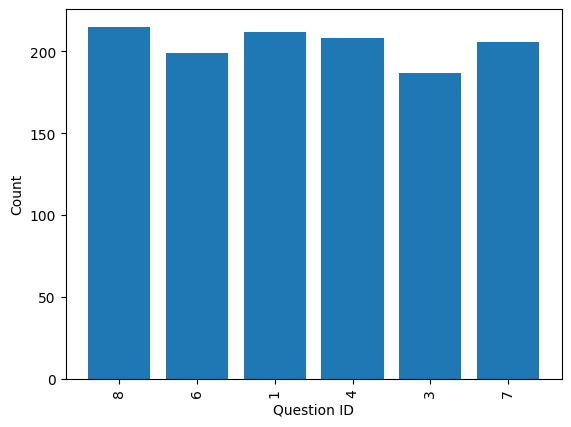

In [23]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the occurrences of each question_id
question_counts = Counter(q['question_id'] for q in training_data)

# Plot the histogram
plt.bar(question_counts.keys(), question_counts.values())
plt.xlabel('Question ID')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

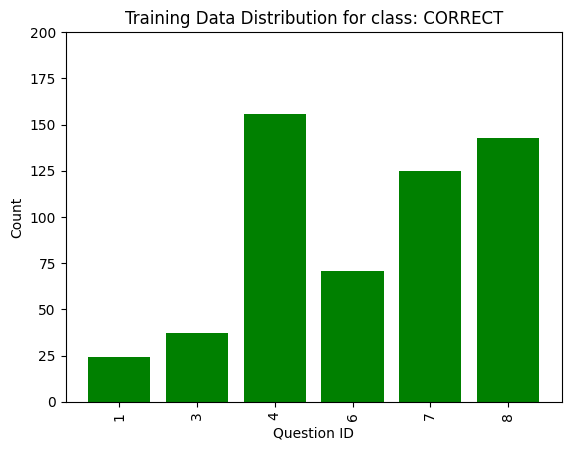

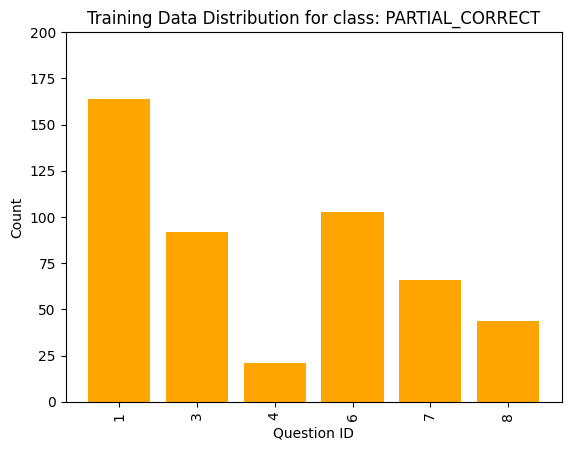

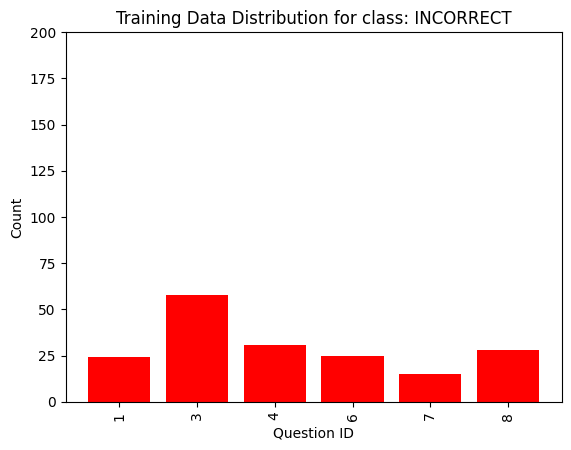

In [24]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the occurrences of each question_id
for l, c in zip(['CORRECT', 'PARTIAL_CORRECT', 'INCORRECT'],  ['green', 'orange', 'red']):
    question_counts = Counter(q['question_id'] for q in training_data if q['label']==l)
    question_counts = sorted(question_counts.items(), key=lambda x: x[0])
    question_counts = {k: v for k, v in question_counts}
    # Plot the histogram
    
    plt.bar(question_counts.keys(), question_counts.values(), color=c)
    plt.title('Training Data Distribution for class: ' + str(l) )
    plt.xlabel('Question ID')
    plt.xticks(rotation=90)
    plt.ylim((0,200))
    plt.ylabel('Count')
    plt.show()

In [25]:
# correlation between classification performance and rubric length

from scipy.stats import pearsonr

x = [4, 3, 4, 11, 7, 7, 12, 11, 10, 4, 6, 5, 2, 2, 6, 2, 2, 16, 3, 2, 3, 2, 2, 2, 2, 6, 1, 16, 7, 2, 10, 6, 5, 6, 4, 2, 18, 3, 2]
y = [0.456, 0.403, 0.303, 0.208, 0.154, 0.222, 0.241, 0.45, 0.25, 0.364, 0.788, 0.775, 0.46, 0.718, 1.0, 0.478, 0.333, 0.622, 0.496, 0.287, 1.0, 0.241, 0.333, 0.237, 0.474, 0.495, 0.489, 0.455, 0.397, 0.43, 1.0, 0.394, 0.442, 0.636, 0.419, 0.307, 0.289, 0.356, 0.222]

corr, pvalue = pearsonr(x, y)
print(f"Pearson correlation coefficient: {corr:.3f}, p-value: {pvalue:.3f}")


Pearson correlation coefficient: 0.011, p-value: 0.949
